# Correlação cruzada e casamento de template

## Exemplo 1D

### Comparando sinais

Quais curvas são mais parecidas? Quais curvas estão mais correlacionadas?

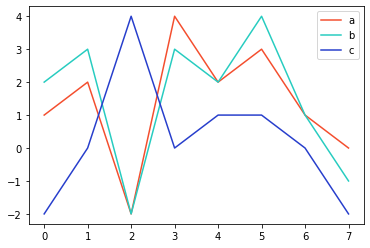

In [230]:
import matplotlib.pyplot as plt
import numpy as np

a = np.array((1,2,-2,4,2,3,1,0))
b = np.array((2,3,-2,3,2,4,1,-1))
c = np.array((-2,0,4,0,1,1,0,-2))

plt.plot(a, color="#f44e2e", label='a')
plt.plot(b, color="#27ccc0", label='b')
plt.plot(c, color="#273ecc", label='c')
plt.legend()

Vamos calcular a correlação entre elas:

In [220]:
print('Correlação entre `a` e `b`: ', (a*b).sum())
print('Correlação entre `a` e `c`: ', (a*c).sum())
print('Correlação entre `b` e `c`: ', (b*c).sum())

Correlação entre `a` e `b`:  41
Correlação entre `a` e `c`:  -5
Correlação entre `b` e `c`:  -4


### Localização "temporal"

Vamos imaginar agora a seguinte situação:

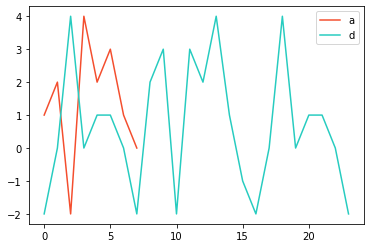

In [231]:
d = np.concatenate((c,b,c))

plt.plot(a, color="#f44e2e", label='a')
plt.plot(d, color="#27ccc0", label='d')
plt.legend()

Nós precisamos "deslizar" com o sinal `a` ao longo de `d`. Para cada posição, fazemos o produto interno entre os vetores que estão alinhados.

Repare que o resultado é menor do que o sinal `d`. Simplesmente não é possivel "encaixar" `a` em todas as posições de `d`. A saída então tem tamanho: `len(d) - len(a) + 1`

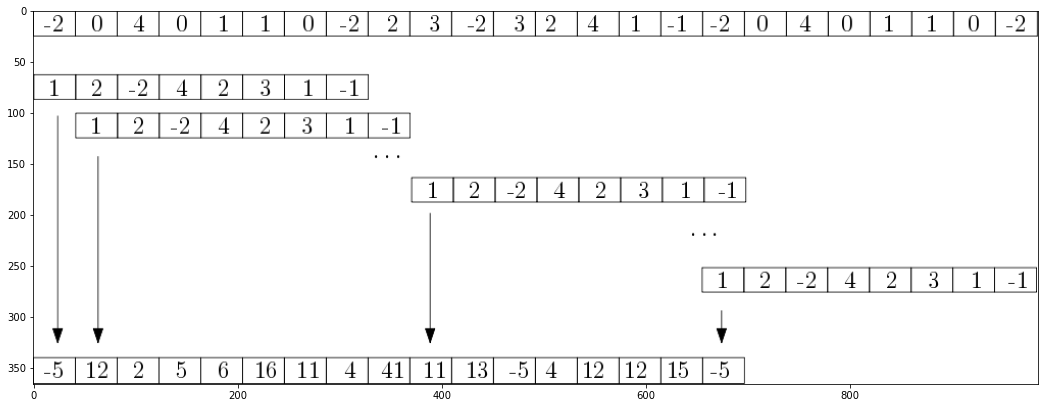

In [222]:
plt.figure(figsize=(18,10))
plt.imshow(cv2.imread('correlation.png'))

Usando o python para calcular e plotando, obtemos:

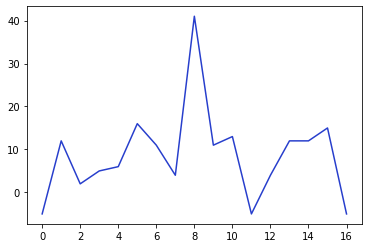

In [232]:
corr_1d = np.asarray(
    [(a*d[i:i+len(a)]).sum() for i in range(len(d)-len(a)+1)]
)
plt.plot(corr_1d, color="#273ecc", label='corr')

O pico acontece na posição 8 quando o sinal `a` fica alinhado com o sinal `b` que compõe `d = (c,b,c)`, que vai da posição 8 até a 15. Repare que o valor em `corr_1d[8] = 41`, como calulamos acima: `(a*b).sum() = 41`. Confira:

In [224]:
corr_1d[8]

41

### Energia do sinal

O que aconteceria se o sinal `d` tivesse 100x mais energia?

Lembrando que energia de um sinal é: $\sum_i d[i]^2 $ (dica: pense um sinal como um vetor e lembre das aulas de alg. lin)

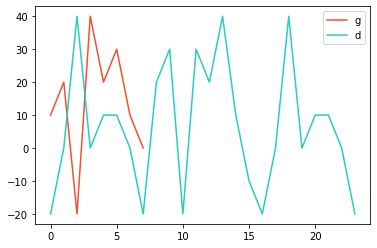

In [235]:
e = 10*np.concatenate((c,b,c))
g = 10*a
plt.plot(g, color="#f44e2e", label='g')
plt.plot(e, color="#27ccc0", label='d')
plt.legend()

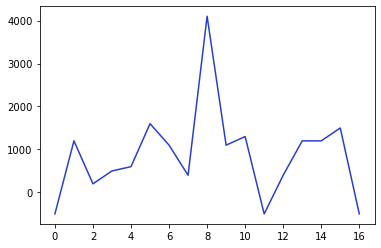

In [236]:
corr_1d = np.asarray(
    [(g*e[i:i+len(g)]).sum()
     for i in range(len(e)-len(a)+1)]
)
plt.plot(corr_1d, color="#273ecc", label='corr')

Notamos que a posição de pico continua a mesma. Na verdade, a curva possui o mesmo, porém o valores das ordenadas estão todos 10x maior!

O que aconteceria se tivessmos um algoritmo que determina os locais mais parecidos a partir de um limiar?

A situação seria semelhante se nosso *template* (o sinal `a`), tivesse $1/9$ da energia:

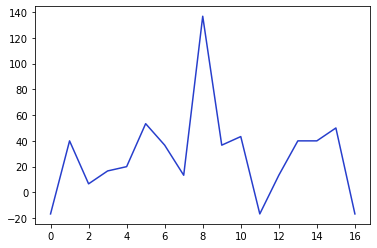

In [211]:
f = a/3

corr_1d = np.asarray([(f*e[i:i+len(f)]).sum() for i in range(len(e)-len(f)+1)])
plt.plot(corr_1d, color="#273ecc", label='corr')

Por que invariância a energia do sinal é relevante? 

Para isso, vamos responder com outra pergunta: O que você acharia se ao aumentar o volume da música, não a conseguisse reconhecer mais?

Para evitar essa dependência na escala do sinal, nós normalizamos pela energia de `f` e `e`. Então, se o sinal é 3x mais forte não fará diferença pois esse ganho será neutralizado ao dividirmos o total de energia. Repare:

In [213]:
ncorr_1d_1 = np.asarray([(f*e[i:i+len(f)]).sum()/np.sqrt(np.square(f).sum()*np.square(e[i:i+len(f)]).sum()) for i in range(len(e)-len(f)+1)])
ncorr_1d_2 = np.asarray([(a*e[i:i+len(f)]).sum()/np.sqrt(np.square(a).sum()*np.square(e[i:i+len(a)]).sum()) for i in range(len(e)-len(a)+1)])
ncorr_1d_3 = np.asarray([(a*d[i:i+len(f)]).sum()/np.sqrt(np.square(a).sum()*np.square(d[i:i+len(a)]).sum()) for i in range(len(d)-len(a)+1)])

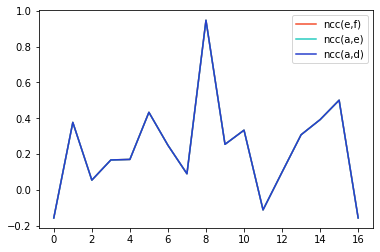

In [214]:
plt.plot(ncorr_1d_1, color="#f44e2e", label='ncc(e,f)')
plt.plot(ncorr_1d_2, color="#27ccc0", label='ncc(a,e)')
plt.plot(ncorr_1d_3, color="#273ecc", label='ncc(a,d)')
plt.legend()

Repare que agora você vê apenas 1 curva, a última plotada. Isso corre pois todas estão superpostas!

## Exemplo 2D

É aqui que as coisas começam a ficar interessante para nós!

Vamos mostrar com uma aplicação: como localizar um olho em uma imagem?

Especificamente, aqui está nosso modelo de olho:

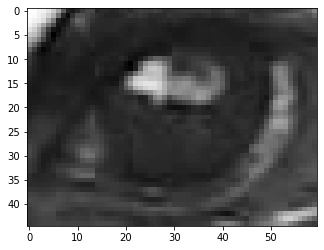

In [54]:
from scipy import misc

plt.imshow(misc.face(gray=True)[310:355, 690:750], cmap='gray')

In [55]:
from scipy import signal

/home/lpcinelli/miniconda3/envs/academy/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


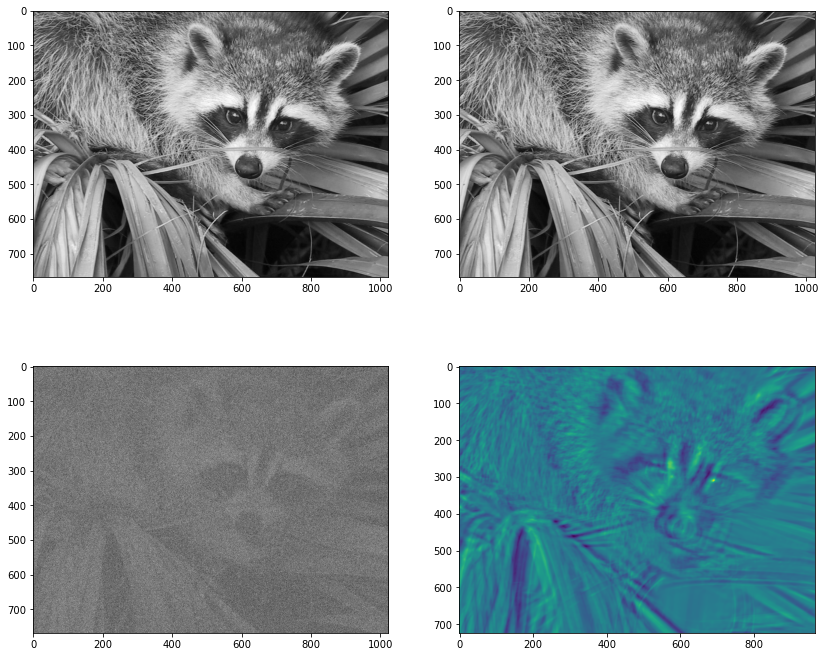

In [144]:
fig, axes = plt.subplots(2,2, figsize=(14,12))
axes = axes.flatten()

face = misc.face(gray=True)
axes[0].imshow(face, cmap='gray')

face = face - misc.face(gray=True).mean() # removes mean
axes[1].imshow(face, cmap='gray')

template = np.copy(face[310:355, 690:750])  # right eye
template -= template.mean()

noisy_face = face + np.random.randn(*face.shape) * 250  # adds noise
axes[2].imshow(noisy_face, cmap='gray')

corr = signal.correlate2d(face, template, mode='valid') # matches template
# axes[3].imshow(corr, cmap='jet')
axes[3].imshow(corr)

fig.show()

In [143]:
print('Posição de máximo na imagem: {}'.format(np.argmax(corr)))
print('Posição de máximo na imagem: {}'.format(np.unravel_index(np.argmax(corr), corr.shape)))

Posição de máximo na imagem: 299840
Posição de máximo na imagem: (310, 690)
